In [1]:
run_gridsearch = False
skip_best_model_train = True,
GPU_SETTING = 0
NUM_ENSEMBLES = 5
hyperparam_csv_file = "warm_springs_daily_hyperparams.csv"

In [2]:
import sys
import os
import itertools
import pandas as pd
current_dir = os.getcwd()
print(current_dir)

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all


In [3]:
library_path = os.path.join('..', '..', '..','..','UCB-USACE-LSTMs')
sys.path.insert(0, library_path)
print(sys.path)

['..\\..\\..\\..\\UCB-USACE-LSTMs', 'F:\\Dino\\UCB-USACE-LSTMs\\UCB_training\\models\\warm_springs_all', 'C:\\Users\\Dino\\anaconda3\\python312.zip', 'C:\\Users\\Dino\\anaconda3\\DLLs', 'C:\\Users\\Dino\\anaconda3\\Lib', 'C:\\Users\\Dino\\anaconda3', '', 'C:\\Users\\Dino\\anaconda3\\Lib\\site-packages', 'C:\\Users\\Dino\\anaconda3\\Lib\\site-packages\\win32', 'C:\\Users\\Dino\\anaconda3\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\Dino\\anaconda3\\Lib\\site-packages\\Pythonwin']


In [4]:
from pathlib import Path
from neuralhydrology.evaluation.metrics import *
from UCB_training.UCB_train import UCB_trainer
from UCB_training.UCB_utils import (combinedPlot, fancyCombinedPlot, combinedPlotFromDf, fancyCombinedPlotFromDf, fractional_multi_lr)

In [5]:
current_path = os.getcwd()
library_path = current_path.split('UCB-USACE-LSTMs')[0] + 'UCB-USACE-LSTMs'

target_path = os.path.join(library_path, 'UCB_training', 'models', 'warm_springs_all')

if os.path.exists(target_path):
    os.chdir(target_path)
    print("Current Working Directory:", os.getcwd())
    print("Train Basin File Exists:", os.path.exists("warm_springs")) 
else:
    print(f"Error: The target path '{target_path}' does not exist.")

Current Working Directory: F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all
Train Basin File Exists: False


In [6]:
path_to_csv = Path(library_path +'/russian_river_data')
path_to_yaml = Path("warm_springs_dam_nlayer.yaml")
path_to_physics_data = Path(library_path + "/russian_river_data/WarmSprings_Inflow_daily_shift.csv")

In [7]:
features_with_physics = [
    #from daily.csv
    "DRY CREEK 20 PRECIP-INC SCREENED",
    "DRY CREEK 20 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "DRY CREEK 30 PRECIP-INC SCREENED",
    "DRY CREEK 30 ET-POTENTIAL RUN:BASIN AVERAGE 60 YR",
    "UKIAH CA HUMIDITY USAF-NOAA",
    "UKIAH CA SOLAR RADIATION USAF-NOAA",
    "UKIAH CA TEMPERATURE USAF-NOAA",
    "UKIAH CA WINDSPEED USAF-NOAA",
    "SANTA ROSA CA HUMIDITY USAF-NOAA",
    "SANTA ROSA CA SOLAR RADIATION USAF-NOAA",
    "SANTA ROSA CA TEMPERATURE USAF-NOAA",
    "SANTA ROSA CA WINDSPEED USAF-NOAA",
    #from Warm_Spring_Inflow.csv
    'Dry Creek 20 ET-POTENTIAL',
    'Dry Creek 20 FLOW',
    'Dry Creek 20 FLOW-BASE',
    'Dry Creek 20 INFILTRATION',
    'Dry Creek 20 PERC-SOIL',
    'Dry Creek 20 SATURATION FRACTION',
    'Dry Creek 30 ET-POTENTIAL',
    'Dry Creek 30 FLOW',
    'Dry Creek 30 FLOW-BASE',
    'Dry Creek 30 INFILTRATION',
    'Dry Creek 30 PERC-SOIL',
    'Dry Creek 30 SATURATION FRACTION',
    'Warm Springs Dam Inflow FLOW',
]

In [8]:
hyperparam_space = {
    "hidden_size": [64, 128, 256],
    "seq_length": [90, 120],
    "num_layers": [1],
    "epochs": [16, 32, 48],
    "batch_size": [64, 128, 256],
    "schedule_pairs": [
        ((0.5, 0.25), (0.01, 0.005, 0.001))
    ]
}

fixed_dropout = 0.4
no_physics_results = []
physics_results = []

In [9]:
from datetime import datetime
start_time = datetime.utcnow()
print("Start time:", start_time.strftime("%Y-%m-%d %H:%M:%S"))

Start time: 2025-05-15 19:08:56


C:\Users\Dino\AppData\Local\Temp\ipykernel_60744\901109023.py:2: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_time = datetime.utcnow()


In [10]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seq, nl, ep, bs, schedule_pair) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"],
            hyperparam_space["batch_size"],
            hyperparam_space["schedule_pairs"]):

        (frac1, frac2), (lr1, lr2, lr3) = schedule_pair
        fractions = [frac1, frac2]
        lr_list = [lr1, lr2, lr3]

        lr_dict = fractional_multi_lr(
            epochs=ep,
            fractions=fractions,
            lrs=lr_list,
            round_up=True)

        hp = {
            "hidden_size": hs,
            "seq_length": seq,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
            "batch_size": bs,
            "learning_rate": lr_dict
        }
        
        print(f"NoPhysics: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=None,
            physics_informed=False,
            physics_data_file=None,
            hourly=False,
            extend_train_period=False,
            gpu=GPU_SETTING
        )
        trainer.train()
        csv_path, metrics_dict = trainer.results()
        
        row_data = {
            "hidden_size": hs,
            "seq_length": seq,
            "num_layers": nl,
            "epochs": ep,
            "batch_size": bs,
            "learning_rate": str(lr_dict),
            "output_dropout": fixed_dropout}
        
        for k, v in metrics_dict.items():
            row_data[k] = v
        no_physics_results.append(row_data)
    df_no_physics = pd.DataFrame(no_physics_results)
    df_no_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_no_physics.reset_index(drop=True, inplace=True)
else:
    print("Skipping Grid-Search")

Skipping Grid-Search


In [11]:
if run_gridsearch or not os.path.exists(hyperparam_csv_file):
    for (hs, seq, nl, ep, bs, schedule_pair) in itertools.product(
            hyperparam_space["hidden_size"],
            hyperparam_space["seq_length"],
            hyperparam_space["num_layers"],
            hyperparam_space["epochs"],
            hyperparam_space["batch_size"],
            hyperparam_space["schedule_pairs"]):

        (frac1, frac2), (lr1, lr2, lr3) = schedule_pair
        fractions = [frac1, frac2]
        lr_list = [lr1, lr2, lr3]

        lr_dict = fractional_multi_lr(
            epochs=ep,
            fractions=fractions,
            lrs=lr_list,
            round_up=True)

        hp = {
            "hidden_size": hs,
            "seq_length": seq,
            "num_layers": nl,
            "epochs": ep,
            "output_dropout": fixed_dropout,
            "batch_size": bs,
            "learning_rate": lr_dict
        }
        
        print(f"Physics: {hp}")
        trainer = UCB_trainer(
            path_to_csv_folder=path_to_csv,
            yaml_path=path_to_yaml,
            hyperparams=hp,
            input_features=features_with_physics,
            physics_informed=True,
            physics_data_file=path_to_physics_data,
            hourly=False,
            extend_train_period=False,
            gpu=GPU_SETTING
        )
        trainer.train()
        csv_path, metrics_dict = trainer.results()
        
        row_data = {
            "hidden_size": hs,
            "seq_length": seq,
            "num_layers": nl,
            "epochs": ep,
            "batch_size": bs,
            "learning_rate": str(lr_dict),
            "output_dropout": fixed_dropout}
        
        for k, v in metrics_dict.items():
            row_data[k] = v
        physics_results.append(row_data)
    df_physics = pd.DataFrame(physics_results)
    df_physics.sort_values(by="NSE", ascending=False, inplace=True)
    df_physics.reset_index(drop=True, inplace=True)
    best_no_phys = df_no_physics.iloc[0].to_dict()
    best_phys = df_physics.iloc[0].to_dict()
    best_no_phys["model_type"] = "no_physics"
    best_phys["model_type"] = "physics"
    best_params_df = pd.DataFrame([best_no_phys, best_phys])
    best_params_df.to_csv(hyperparam_csv_file, index=False)
else:
    print("Skipping Grid-Search")

Skipping Grid-Search


In [12]:
if os.path.exists(hyperparam_csv_file):
    best_params_df = pd.read_csv(hyperparam_csv_file)
    best_no_phys = best_params_df.query("model_type == 'no_physics'").iloc[0].to_dict()
    best_phys = best_params_df.query("model_type == 'physics'").iloc[0].to_dict()

    best_no_physics_params = {
        "epochs": int(best_no_phys["epochs"]),
        "hidden_size": int(best_no_phys["hidden_size"]),
        "seq_length": int(best_no_phys["seq_length"]),
        "num_layers": int(best_no_phys["num_layers"]),
        "output_dropout": float(best_no_phys["output_dropout"]),
        "batch_size": int(best_no_phys["batch_size"]),
        "learning_rate": eval(best_no_phys["learning_rate"])
    }

    best_physics_params = {
        "epochs": int(best_phys["epochs"]),
        "hidden_size": int(best_phys["hidden_size"]),
        "seq_length": int(best_phys["seq_length"]),
        "num_layers": int(best_phys["num_layers"]),
        "output_dropout": float(best_phys["output_dropout"]),
        "batch_size": int(best_phys["batch_size"]),
        "learning_rate": eval(best_phys["learning_rate"])
    }
    print("\nLoaded best hyperparams from CSV:")
    print("Best NO-PHYS:", best_no_physics_params)
    print("Best PHYS:", best_physics_params)
else:
    print(f"Error: {hyperparam_csv_file} not found. Did you run gridsearch?")


Loaded best hyperparams from CSV:
Best NO-PHYS: {'epochs': 48, 'hidden_size': 128, 'seq_length': 120, 'num_layers': 1, 'output_dropout': 0.4, 'batch_size': 128, 'learning_rate': {0: 0.01, 24: 0.005, 36: 0.001}}
Best PHYS: {'epochs': 48, 'hidden_size': 64, 'seq_length': 90, 'num_layers': 1, 'output_dropout': 0.4, 'batch_size': 256, 'learning_rate': {0: 0.01, 24: 0.005, 36: 0.001}}


In [13]:
if run_gridsearch:
    print(df_no_physics.iloc[0:4])
    df_no_physics.to_csv("warm_springs_daily_no_physics_gridsearch.csv", index=False)

In [14]:
if run_gridsearch:
    print(df_physics.iloc[0:4])
    df_physics.to_csv("warm_springs_daily_physics_gridsearch.csv", index=False)

### Re-run validation with best hyperparameters

In [16]:
if not skip_best_model_train:
    lstmNoPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING
    )
    lstmNoPhysicsValBest.train()
    no_physics_val_csv, no_physics_val_metrics = lstmNoPhysicsValBest.results()
    no_physics_val_metrics

In [17]:
if not skip_best_model_train:
    lstmPhysicsValBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=False,
        gpu=GPU_SETTING
    )
    lstmPhysicsValBest.train()
    physics_val_csv, physics_val_metrics = lstmPhysicsValBest.results()
    physics_val_metrics

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be rem

[INFO] Wrote metrics CSV: warm_springs_daily_val_metrics.csv


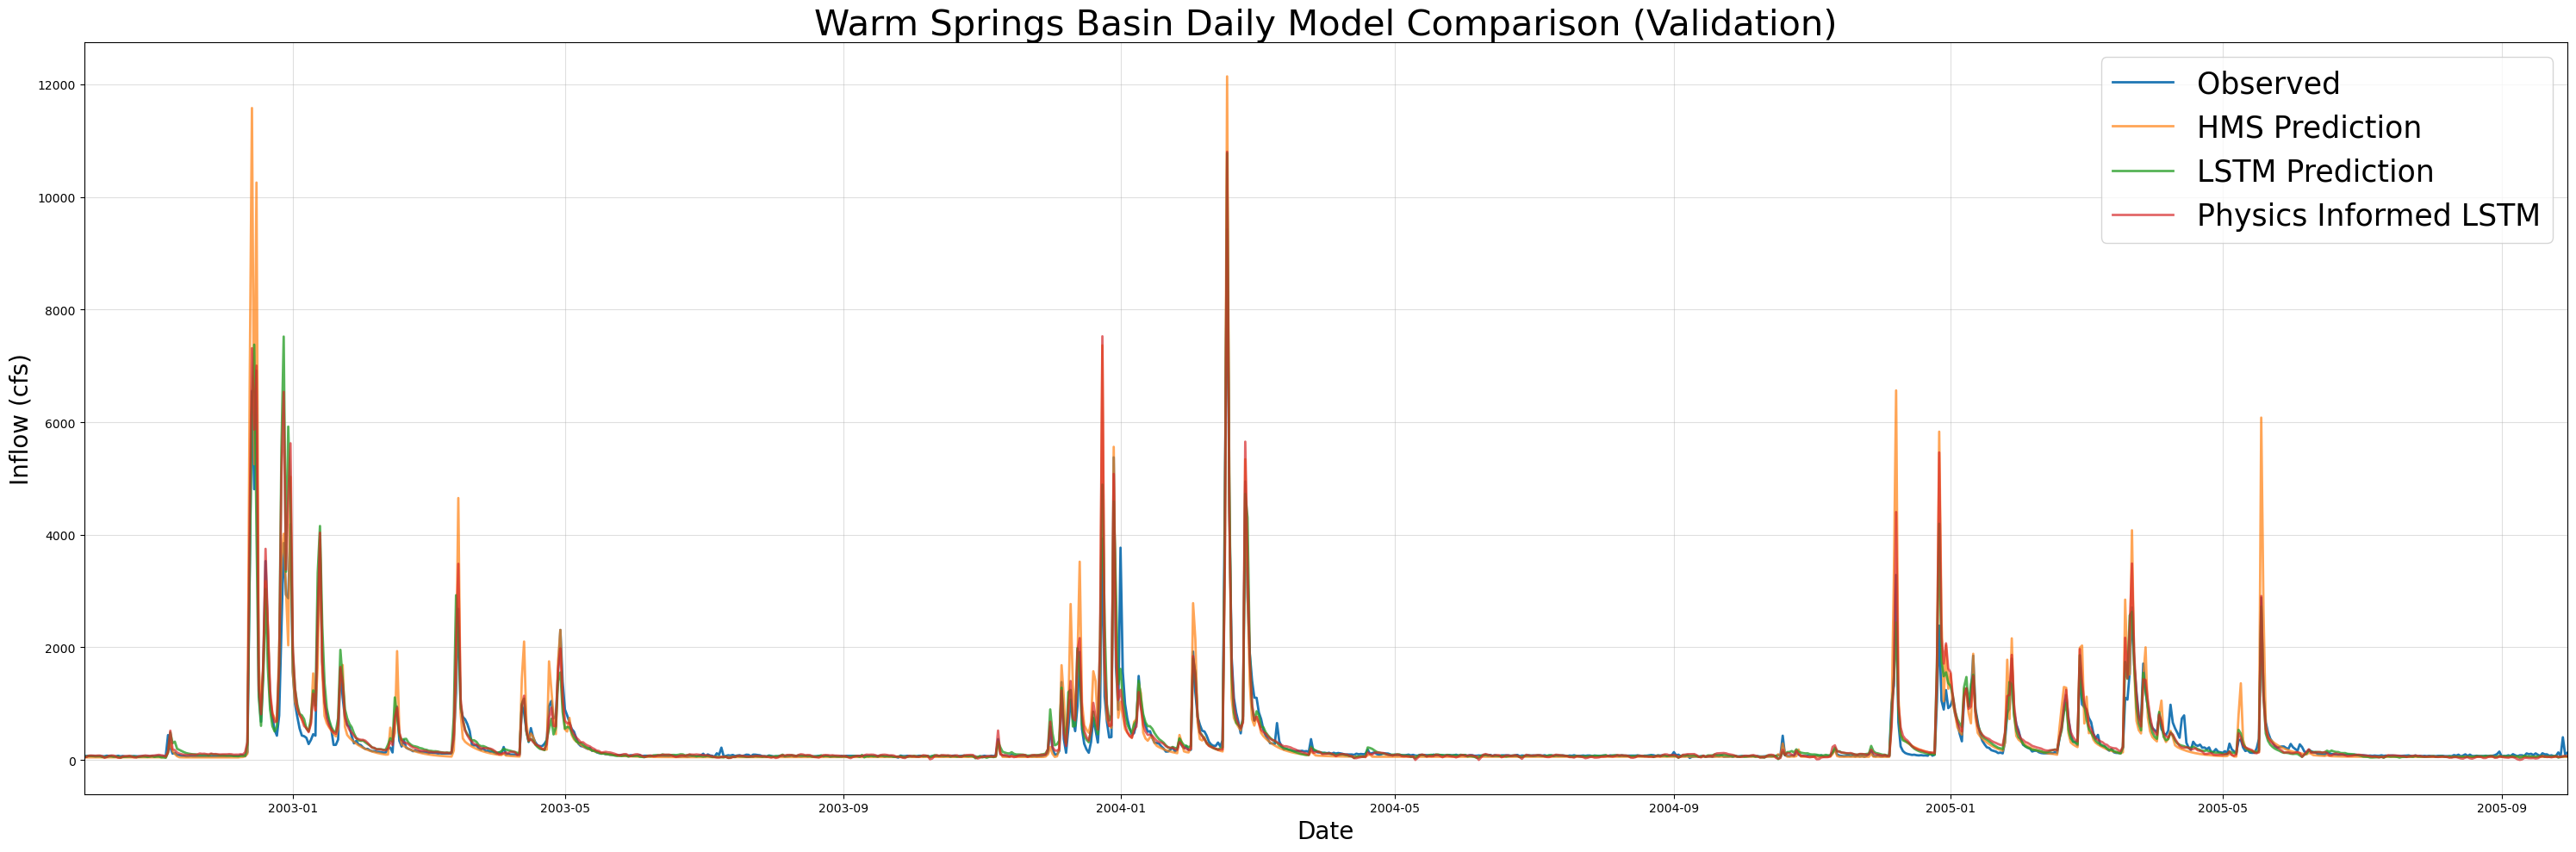

In [18]:
if not skip_best_model_train:
    combinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,
        title="Warm Springs Basin Daily Model Comparison (Validation)",
        fName="warm_springs_daily_val_metrics.csv",
        plot_filename="warm_springs_daily_val_model_comparison.png",
        timeseries_filename ="warm_springs_daily_val_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("warm_springs_daily_val_combined_ts.csv")
    combinedPlotFromDf(combined_df, title="Warm Springs Basin Daily Model Comparison (Validation)", fName="warm_springs_daily_val_metrics.csv")

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be rem

[INFO] Wrote metrics CSV: warm_springs_daily_val_metrics.csv


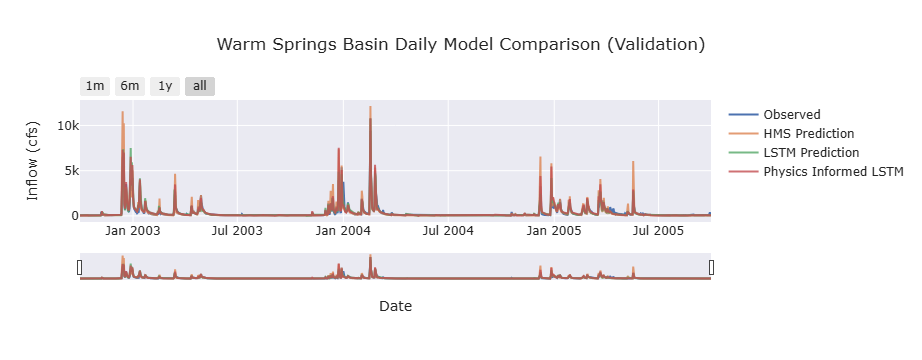

In [19]:
if not skip_best_model_train:
    fancyCombinedPlot(
        lstm_results=no_physics_val_csv,
        lstmPhysics_results=physics_val_csv,
        HMS_results=path_to_physics_data,
        title='Warm Springs Basin Daily Model Comparison (Validation)',
        fName="warm_springs_daily_val_metrics.csv",
        timeseries_filename ="warm_springs_daily_val_combined_ts.csv"
    )
else:
    fancyCombinedPlotFromDf(combined_df, title='Warm Springs Basin Daily Model Comparison (Validation)',
                             fName="warm_springs_daily_val_metrics.csv")

In [20]:
if skip_best_model_train:
    val_metrics = pd.read_csv("warm_springs_daily_val_metrics.csv", index_col=0)
    print(val_metrics)

                       HMS          LSTM  Physics_Informed_LSTM
NSE               0.695953      0.832832               0.854659
MSE          149072.347123  81961.443220           71259.597336
RMSE            386.098883    286.289090             266.944933
KGE               0.629025      0.833929               0.777180
Alpha-NSE         1.354620      1.128169               1.190491
Beta-KGE          1.087268      1.082311               1.106571
Beta-NSE          0.040572      0.038267               0.049546
Pearson-r         0.934799      0.933841               0.955229
FHV              34.412169     13.542671              22.334035
FMS              11.222054      4.019818               3.611877
FLV              75.843904   -135.852858           -2733.440710
Peak-Timing       0.000000      0.200000               0.000000
Peak-MAPE        57.593945     23.895835              13.002124
PBIAS            -8.726809     -8.231130             -10.657133


### Re-run testing with best hyperparameters

In [22]:
if not skip_best_model_train:
    lstmNoPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_no_physics_params,
        input_features=None,
        physics_informed=False,
        physics_data_file=None,
        hourly=False,
        extend_train_period=True,  
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
    )
    
    lstmNoPhysicsExtBest.train()
    no_physics_test_csv, no_physics_test_metrics = lstmNoPhysicsExtBest.results('test')
    no_physics_test_metrics

In [23]:
if not skip_best_model_train:
    lstmPhysicsExtBest = UCB_trainer(
        path_to_csv_folder=path_to_csv,
        yaml_path=path_to_yaml,
        hyperparams=best_physics_params,
        input_features=features_with_physics,
        physics_informed=True,
        physics_data_file=path_to_physics_data,
        hourly=False,
        extend_train_period=True,
        gpu=GPU_SETTING,
        # num_ensemble_members = NUM_ENSEMBLES,
    )
    
    lstmPhysicsExtBest.train()
    physics_test_csv, physics_test_metrics = lstmPhysicsExtBest.results('test')
    physics_test_metrics

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\

[INFO] Wrote metrics CSV: warm_springs_daily_test_metrics.csv


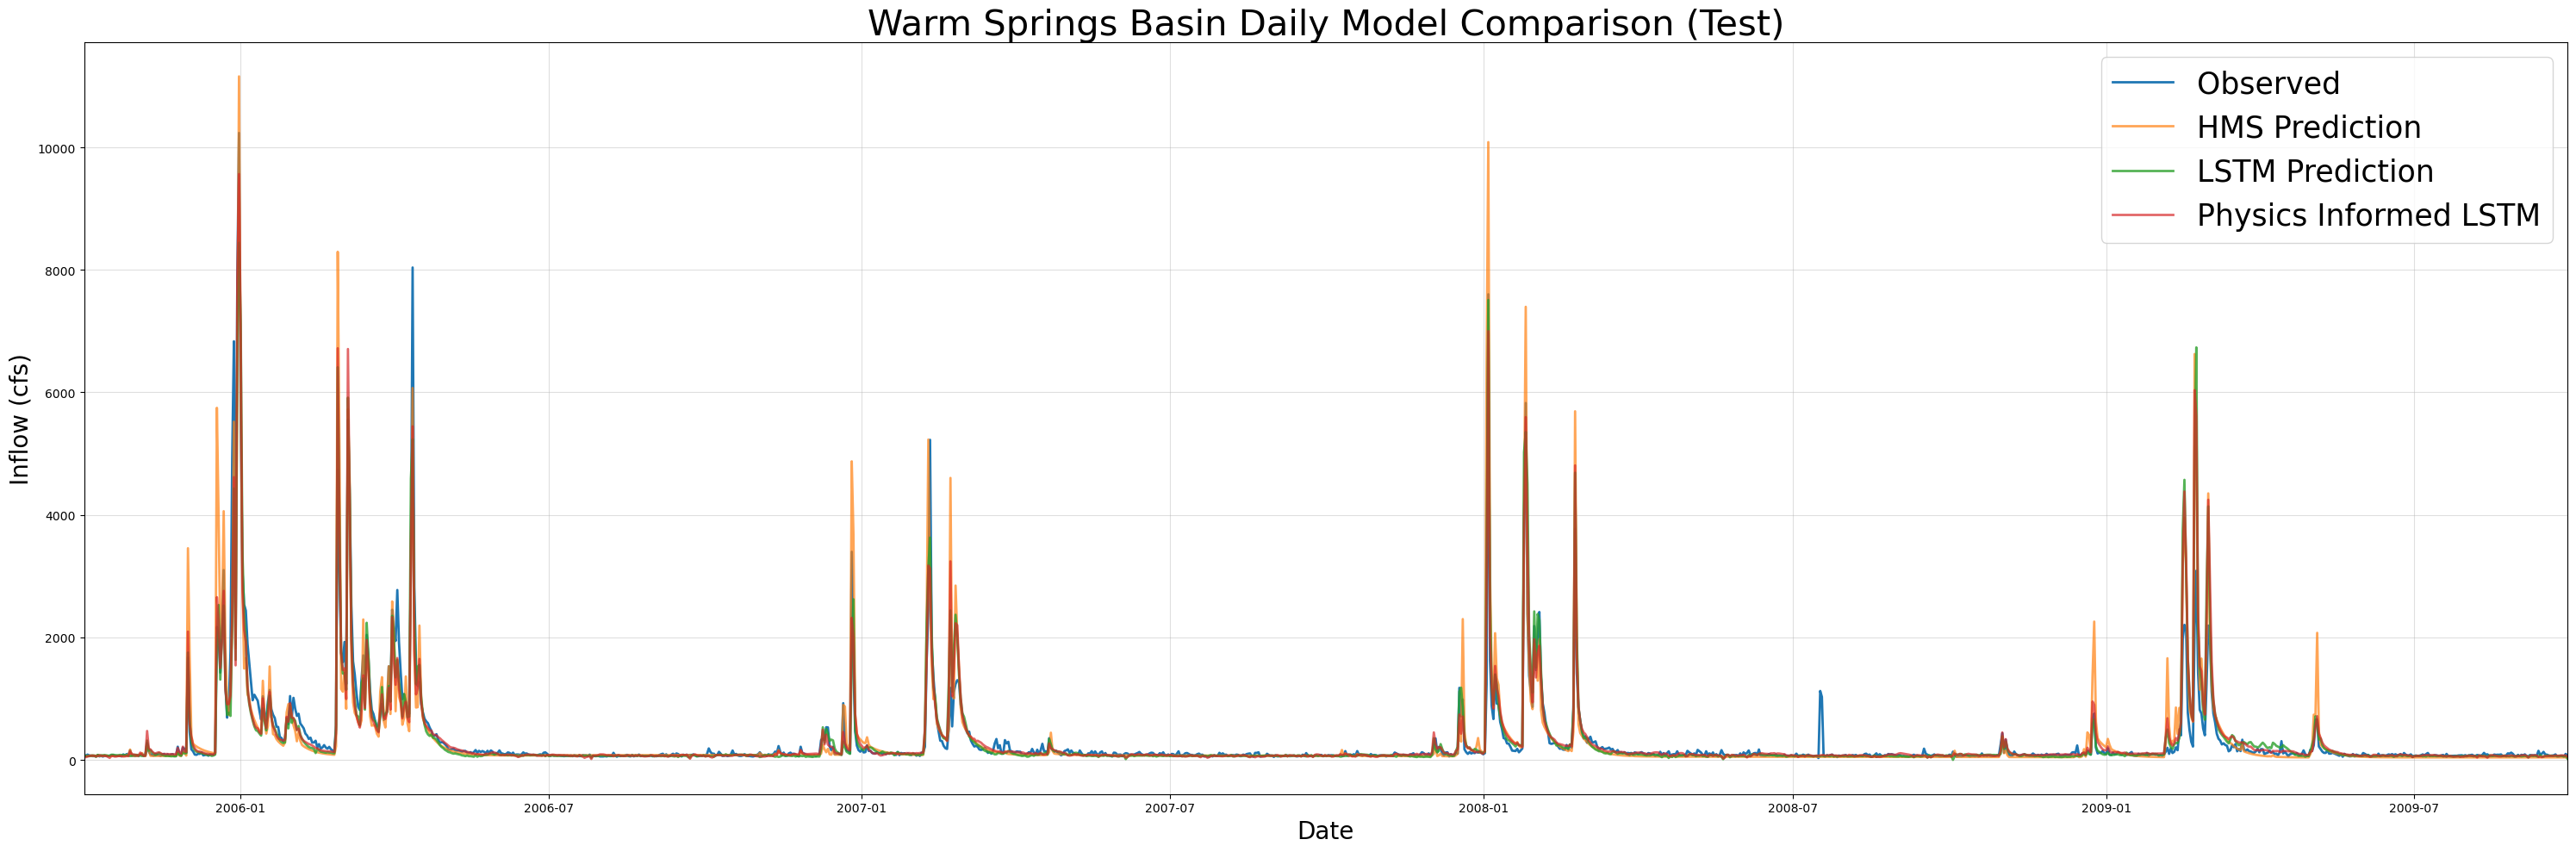

In [24]:
if not skip_best_model_train:
    combinedPlot(
        lstm_results=no_physics_test_csv,
        lstmPhysics_results=physics_test_csv,
        HMS_results=path_to_physics_data,
        title="Warm Springs Basin Daily Model Comparison (Test)",
        fName="warm_springs_daily_test_metrics.csv",
        plot_filename="warm_springs_daily_test_model_comparison.png",
        timeseries_filename ="warm_springs_daily_test_combined_ts.csv"
    )
else:
    combined_df = pd.read_csv("warm_springs_daily_test_combined_ts.csv")
    combinedPlotFromDf(combined_df, title="Warm Springs Basin Daily Model Comparison (Test)", fName="warm_springs_daily_test_metrics.csv")

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:339: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\..\UCB-USACE-LSTMs\neuralhydrology\datautils\utils.py:382: FutureWarning:

'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.

F:\Dino\UCB-USACE-LSTMs\UCB_training\models\warm_springs_all\..\..\..\

[INFO] Wrote metrics CSV: warm_springs_daily_test_metrics.csv


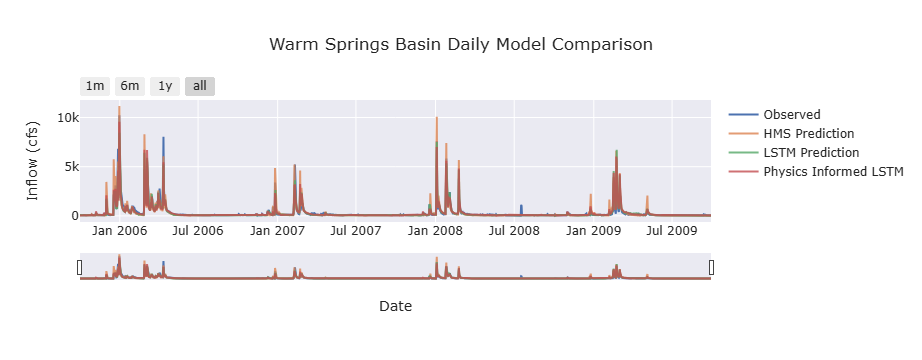

In [25]:
if not skip_best_model_train:
    fancyCombinedPlot(lstm_results=no_physics_test_csv, lstmPhysics_results= physics_test_csv, HMS_results=path_to_physics_data, title='Warm Springs Basin Daily Model Comparison', fName = "warm_springs_daily_test_metrics.csv", timeseries_filename ="warm_springs_daily_test_combined_ts.csv")
else:
    fancyCombinedPlotFromDf(combined_df, title='Warm Springs Basin Daily Model Comparison', fName = "warm_springs_daily_test_metrics.csv")

In [26]:
# if skip_best_model_train:
test_metrics = pd.read_csv("warm_springs_daily_test_metrics.csv", index_col=0)
print(test_metrics)

                       HMS          LSTM  Physics_Informed_LSTM
NSE               0.732375      0.850124               0.869101
MSE          143312.877184  80258.403911           70096.328422
RMSE            378.566873    283.299142             264.757112
KGE               0.791169      0.920423               0.928619
Alpha-NSE         1.179486      1.033454               1.023743
Beta-KGE          1.038166      1.005828               1.022008
Beta-NSE          0.015523      0.002370               0.008951
Pearson-r         0.900309      0.928032               0.936383
FHV              24.454837      7.655971               6.344594
FMS              25.219424     25.555953              20.858974
FLV              79.322057  -2228.814420             -86.190358
Peak-Timing       0.833333      0.166667               0.666667
Peak-MAPE        44.995233     49.493648              43.675505
PBIAS            -3.816588     -0.582760              -2.200844


In [27]:
end_time = datetime.utcnow()
print("\nEnd time:", end_time.strftime("%Y-%m-%d %H:%M:%S"))
print("Total time:", end_time - start_time)


End time: 2025-05-15 19:09:02
Total time: 0:00:05.683189


C:\Users\Dino\AppData\Local\Temp\ipykernel_60744\3925244319.py:1: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).

